# Dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tokenizers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 94.4 MB/s eta 0:00:00


In [ ]:
!pip install -q --upgrade keras-nlp tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 9.3 MB/s eta 0:00:00


In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.8 MB/s eta 0:00:00


In [ ]:
import os
import re
import pickle

import numpy as np
import nltk
import matplotlib.pyplot as plt

from tokenizers import Tokenizer, ByteLevelBPETokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

import keras_nlp
from keras.utils import pad_sequences

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint

from transformers import BertModel, BertConfig
from transformers import PreTrainedTokenizerFast
from transformers import TFBertForPreTraining, TFBertForSequenceClassification

# Loading the Dataset

In [ ]:
directory = ''

In [ ]:
with open(directory + '/IMDB/unsupervised.pickle', 'rb') as file:
    unsupervised = pickle.load(file)
with open(directory + '/IMDB/x_train.pickle', 'rb') as file:
    x_train = pickle.load(file)
with open(directory + '/IMDB/x_val.pickle', 'rb') as file:
    x_val = pickle.load(file)
with open(directory + '/IMDB/x_test.pickle', 'rb') as file:
    x_test = pickle.load(file)

In [ ]:
with open(directory + '/IMDB/y_train.txt', 'r') as file:
    content = file.read().strip().split()
    y_train = np.array([int(bit) for bit in content])
with open(directory + '/IMDB/y_val.txt', 'r') as file:
    content = file.read().strip().split()
    y_val = np.array([int(bit) for bit in content])

# Preprocessing

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
sentence_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

# Split paragraphs into sentences
unsupervised_sentences = []
for paragraph in unsupervised:
    unsupervised_sentences.extend(sentence_tokenizer.tokenize(paragraph))

In [ ]:
def process(x):
    x = re.sub('[,\.!?:()"]', '', x)
    x = re.sub('<.*?>', ' ', x)
    x = re.sub('http\S+', ' ', x)
    x = re.sub('[^a-zA-Z]', ' ', x)
    x = re.sub('\s+', ' ', x)
    return x.lower().strip()

In [ ]:
unsupervised = list(map(process, unsupervised))
unsupervised_sentences = list(map(process, unsupervised_sentences))
x_train = list(map(process, x_train))
x_val = list(map(process, x_val))
x_test = list(map(process, x_test))

# BPE Tokenizer

In [ ]:
tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
trainer = BpeTrainer(special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])
tokenizer.pre_tokenizer = Whitespace()

In [ ]:
with open(directory + '/unsupervised_sentence.txt', 'w') as f:
    f.write(' '.join(unsupervised_sentences))

In [ ]:
tokenizer.train([directory + '/unsupervised_sentence.txt'], trainer)

In [ ]:
tokenizer.save(directory + "/tokenizer.json")

In [ ]:
with open(directory + '/vocab.txt', 'w') as f:
    f.write('\n'.join(tokenizer.get_vocab().keys()))

In [ ]:
tokenizer = Tokenizer.from_file(directory + "/tokenizer.json")

In [ ]:
def tokenize(strs):
    tokenized = []
    for sentence in strs:
        encoded = tokenizer.encode(sentence)
        tokens = encoded.ids
        tokenized.append(tokens)
    return tokenized

In [ ]:
# Tokenize the dataset
tokenized_train = tokenize(x_train)

tokenized_val = tokenize(x_val)

tokenized_test = tokenize(x_test)

tokenized_unsupervised = tokenize(unsupervised_sentences)

In [ ]:
pad_id = tokenizer.encode('[PAD]').ids[0]

In [ ]:
train_array_x = pad_sequences(tokenized_train, maxlen=500, padding='post', truncating='post', value=pad_id)
val_array_x = pad_sequences(tokenized_val, maxlen=500, padding='post', truncating='post', value=pad_id)
test_array_x = pad_sequences(tokenized_test, maxlen=500, padding='post', truncating='post', value=pad_id)
unsupervised_array = pad_sequences(tokenized_unsupervised, maxlen=50, padding='post', truncating='post', value=pad_id)

In [ ]:

# Save the tokenized dataset to a file
filename = "/train_array_x.pkl"
with open(directory + filename, "wb") as file:
    pickle.dump(train_array_x, file)

filename = "/val_array_x.pkl"
with open(directory + filename, "wb") as file:
    pickle.dump(val_array_x, file)

filename = "/test_array_x.pkl"
with open(directory + filename, "wb") as file:
    pickle.dump(test_array_x, file)

filename = "/unsupervised_array.pkl"
with open(directory + filename, "wb") as file:
    pickle.dump(unsupervised_array, file)


In [ ]:
# Read the tokenized dataset from the file
filename = "/train_array_x.pkl"
with open(directory + filename, "rb") as file:
    train_array_x = pickle.load(file)

filename = "/val_array_x.pkl"
with open(directory + filename, "rb") as file:
    val_array_x = pickle.load(file)

filename = "/test_array_x.pkl"
with open(directory + filename, "rb") as file:
    test_array_x = pickle.load(file)

filename = "/unsupervised_array.pkl"
with open(directory + filename, "rb") as file:
    unsupervised_array = pickle.load(file)

# Transformer Encoder

In [ ]:
def transformer_encoder_model(hyperparams, batch_size = 128, num_epochs = 10, learning_rate=0.01):
    # Clear any previous TensorFlow graph
    tf.keras.backend.clear_session()

    # Enable GPU acceleration
    tf.config.experimental.set_visible_devices(tf.config.list_physical_devices('GPU'), 'GPU')

    # Define the Transformer encoder model
    encoder_layer = keras_nlp.layers.TransformerEncoder(
        intermediate_dim=hyperparams['embedding_dim'],
        num_heads=hyperparams['num_heads'])

    # Define the classification head
    classification_head = tf.keras.layers.Dense(2, activation='softmax')

    # Create the Transformer model
    inputs = tf.keras.Input(shape=(None,), dtype=tf.int32)
    embedding = tf.keras.layers.Embedding(tokenizer.get_vocab_size(), hyperparams['embedding_dim'])(inputs)

    for _ in range(hyperparams['num_layers']):
        encoder_output = encoder_layer(embedding)

    classification_output = classification_head(encoder_output[:, 0, :])  # Use only the first token's representation

    model = tf.keras.Model(inputs=inputs, outputs=classification_output)

    # Compile the model
    loss = tf.keras.losses.SparseCategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    # Train the model
    history = model.fit(train_array_x, y_train, batch_size, num_epochs, validation_data=(val_array_x, y_val))

    return model, history

In [ ]:
# Define hyperparameters
hyperparameters = [
    {'num_layers': 2, 'num_heads': 2, 'embedding_dim': 32},
    {'num_layers': 4, 'num_heads': 1, 'embedding_dim': 16},
    {'num_layers': 4, 'num_heads': 1, 'embedding_dim': 32}
]


In [ ]:
model = [None, None, None]

history = [None, None, None]

In [ ]:
model[0], history[0] = transformer_encoder_model(hyperparameters[0])

Epoch 1/10
782/782 [==============================] - 103s 128ms/step - loss: 0.4614 - accuracy: 0.7650 - val_loss: 0.3307 - val_accuracy: 0.8679
Epoch 2/10
782/782 [==============================] - 52s 67ms/step - loss: 0.2191 - accuracy: 0.9148 - val_loss: 0.3169 - val_accuracy: 0.8819
Epoch 3/10
782/782 [==============================] - 29s 37ms/step - loss: 0.1383 - accuracy: 0.9509 - val_loss: 0.3926 - val_accuracy: 0.8639
Epoch 4/10
782/782 [==============================] - 24s 31ms/step - loss: 0.0968 - accuracy: 0.9661 - val_loss: 0.4578 - val_accuracy: 0.8595
Epoch 5/10
782/782 [==============================] - 25s 32ms/step - loss: 0.0799 - accuracy: 0.9741 - val_loss: 0.5150 - val_accuracy: 0.8633
Epoch 6/10
782/782 [==============================] - 19s 24ms/step - loss: 0.0546 - accuracy: 0.9820 - val_loss: 0.5237 - val_accuracy: 0.8631
Epoch 7/10
782/782 [==============================] - 18s 24ms/step - loss: 0.0598 - accuracy: 0.9804 - val_loss: 0.5036 - val_accurac

In [ ]:
model[1], history[1] = transformer_encoder_model(hyperparameters[1])

Epoch 1/10
782/782 [==============================] - 129s 160ms/step - loss: 0.4016 - accuracy: 0.7990 - val_loss: 0.2964 - val_accuracy: 0.8773
Epoch 2/10
782/782 [==============================] - 54s 69ms/step - loss: 0.1888 - accuracy: 0.9311 - val_loss: 0.3048 - val_accuracy: 0.8816
Epoch 3/10
782/782 [==============================] - 31s 39ms/step - loss: 0.1073 - accuracy: 0.9605 - val_loss: 0.3995 - val_accuracy: 0.8724
Epoch 4/10
782/782 [==============================] - 26s 33ms/step - loss: 0.0721 - accuracy: 0.9746 - val_loss: 0.4222 - val_accuracy: 0.8655
Epoch 5/10
782/782 [==============================] - 20s 26ms/step - loss: 0.0485 - accuracy: 0.9834 - val_loss: 0.5004 - val_accuracy: 0.8686
Epoch 6/10
782/782 [==============================] - 16s 21ms/step - loss: 0.0361 - accuracy: 0.9873 - val_loss: 0.5481 - val_accuracy: 0.8638
Epoch 7/10
782/782 [==============================] - 15s 19ms/step - loss: 0.0277 - accuracy: 0.9907 - val_loss: 0.6190 - val_accurac

In [ ]:
model[2], history[2] = transformer_encoder_model(hyperparameters[2])

Epoch 1/10
782/782 [==============================] - 102s 126ms/step - loss: 0.4346 - accuracy: 0.7772 - val_loss: 0.2953 - val_accuracy: 0.8841
Epoch 2/10
782/782 [==============================] - 43s 55ms/step - loss: 0.2100 - accuracy: 0.9217 - val_loss: 0.2924 - val_accuracy: 0.8811
Epoch 3/10
782/782 [==============================] - 30s 38ms/step - loss: 0.1344 - accuracy: 0.9513 - val_loss: 0.4231 - val_accuracy: 0.8734
Epoch 4/10
782/782 [==============================] - 20s 26ms/step - loss: 0.1033 - accuracy: 0.9636 - val_loss: 0.4218 - val_accuracy: 0.8614
Epoch 5/10
782/782 [==============================] - 19s 25ms/step - loss: 0.0804 - accuracy: 0.9719 - val_loss: 0.6012 - val_accuracy: 0.8646
Epoch 6/10
782/782 [==============================] - 16s 20ms/step - loss: 0.0531 - accuracy: 0.9820 - val_loss: 0.5774 - val_accuracy: 0.8506
Epoch 7/10
782/782 [==============================] - 15s 19ms/step - loss: 0.0493 - accuracy: 0.9839 - val_loss: 0.6369 - val_accurac

In [ ]:
def plot_history(history, subplot_index):
    # Plot training and validation loss
    plt.subplot(3, 2, subplot_index)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(3, 2, subplot_index + 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

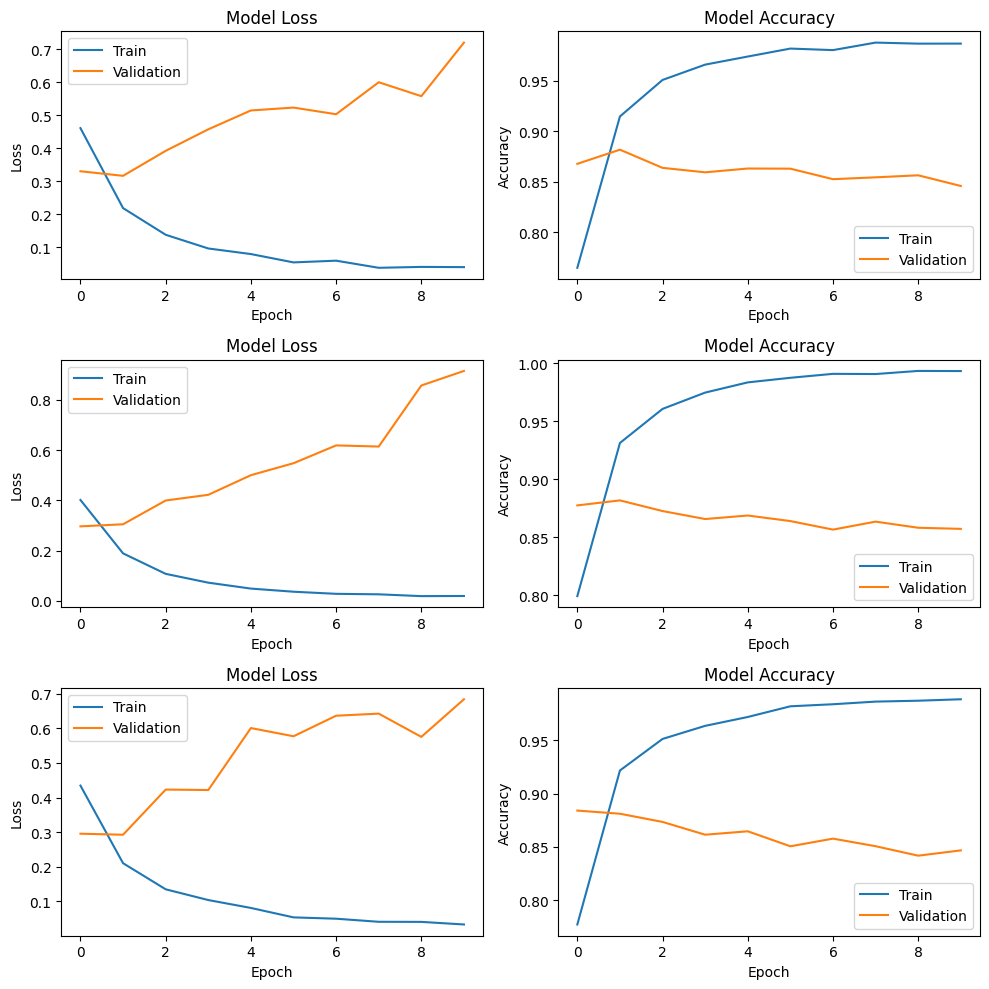

In [ ]:
# Plot the histories
plt.figure(figsize=(10, 10))
plot_history(history[0], 1)
plot_history(history[1], 3)
plot_history(history[2], 5)

# Adjust subplot spacing
plt.tight_layout()

# Display the plot
plt.show()

We are facing overfitting in every model. The highest validation accuracy is achieved at the second epoch of the second model.

In [ ]:
final_model, _ = transformer_encoder_model(hyperparameters[1], num_epochs = 2)

Epoch 1/2
196/196 [==============================] - 72s 305ms/step - loss: 0.5799 - accuracy: 0.6532 - val_loss: 0.3204 - val_accuracy: 0.8642
Epoch 2/2
196/196 [==============================] - 42s 211ms/step - loss: 0.2334 - accuracy: 0.9088 - val_loss: 0.2870 - val_accuracy: 0.8866


In [ ]:
# Make predictions on the test data
predictions = final_model.predict(test_array_x)

# Convert predictions to a numpy array
predictions = list(map(int, np.argmax(predictions, axis=1)))

391/391 [==============================] - 2s 5ms/step


In [ ]:
with open(directory + '/y_test.txt', 'w') as f:
    for prediction in predictions:
        f.write(str(prediction) + '\n')

# Bert

In [ ]:
gpu_device = 0
tf.config.experimental.set_visible_devices(tf.config.experimental.list_physical_devices('GPU')[gpu_device], 'GPU')
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[gpu_device], True)

In [ ]:
# Set the model hyperparameters
num_heads = 4
num_layers = 4
embedding_length = 128

## Self-Supervised

In [ ]:
# Define the vocabulary size
vocab_size = tokenizer.get_vocab_size()

# Define the batch size
batch_size = 180
num_batches = (len(unsupervised_array) // batch_size) + ((len(unsupervised_array) % batch_size) > 0)

num_epochs = 10

# Define the masking probability
mask_prob = 0.15

In [ ]:
# Define the BERT configuration
config = BertConfig(
    vocab_size=vocab_size,
    num_attention_heads=num_heads,
    num_hidden_layers=num_layers,
    hidden_size=embedding_length
)

# Define the model architecture
model = TFBertForPreTraining(config=config)

# Define the masked language modeling (MLM) loss function
mlm_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0: INFO, 1: WARNING, 2: ERROR, 3: FATAL
tf.get_logger().setLevel('ERROR')  # or tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### First Try

In [ ]:
# Function to apply masking to input tokens
def apply_mask(inputs):
    # Copy the input tokens
    masked_inputs = np.copy(inputs)

    # Create a mask array with True values for tokens to be masked
    mask = np.random.rand(*inputs.shape) < mask_prob

    # Replace the tokens with a custom mask token ID
    masked_inputs[mask] = tokenizer.encode('[MASK]').ids[0]

    return masked_inputs

In [ ]:
# Pre-training loop
for epoch in range(num_epochs):
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(unsupervised_array))
        batch_inputs = unsupervised_array[start_idx:end_idx]

        with tf.GradientTape() as tape:
            # Apply masking to input tokens
            masked_inputs = np.array([apply_mask(inputs) for inputs in batch_inputs])

            # Forward pass
            outputs = model(masked_inputs, training=True)
            prediction_scores = outputs.prediction_logits

            # Compute the MLM loss
            mlm_loss_value = mlm_loss(batch_inputs, prediction_scores)

        # Backward pass
        gradients = tape.gradient(mlm_loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # Calculate accuracy
        predictions = tf.argmax(prediction_scores, axis=-1)
        accuracy = np.mean(np.equal(batch_inputs, predictions.numpy()))

        # Update the progress
        print(f"Epoch: {epoch + 1}, Batch: {batch_idx + 1}/{num_batches}, Loss: {mlm_loss_value.numpy()}, Accuracy: {accuracy}")

    model.save_pretrained(directory + '/pretrained_model')

Streaming output truncated to the last 5000 lines.
Epoch: 9, Batch: 983/2991, Loss: 0.2197386920452118, Accuracy: 0.9653333333333334
Epoch: 9, Batch: 984/2991, Loss: 0.2637619376182556, Accuracy: 0.9564444444444444
Epoch: 9, Batch: 985/2991, Loss: 0.2773219347000122, Accuracy: 0.9573333333333334
Epoch: 9, Batch: 986/2991, Loss: 0.3614695370197296, Accuracy: 0.9432222222222222
Epoch: 9, Batch: 987/2991, Loss: 0.269733726978302, Accuracy: 0.9564444444444444
Epoch: 9, Batch: 988/2991, Loss: 0.30653074383735657, Accuracy: 0.9521111111111111
Epoch: 9, Batch: 989/2991, Loss: 0.313096284866333, Accuracy: 0.9497777777777778
Epoch: 9, Batch: 990/2991, Loss: 0.37011536955833435, Accuracy: 0.9455555555555556
Epoch: 9, Batch: 991/2991, Loss: 0.3390691876411438, Accuracy: 0.949
Epoch: 9, Batch: 992/2991, Loss: 0.32914289832115173, Accuracy: 0.9466666666666667
Epoch: 9, Batch: 993/2991, Loss: 0.2948046922683716, Accuracy: 0.9535555555555556
Epoch: 9, Batch: 994/2991, Loss: 0.33865126967430115, Accur

In [ ]:

# Save the pre-trained model
# model.save_pretrained(directory + '/pretrained_model')


### Second Try

In [ ]:
model = TFBertForPreTraining.from_pretrained(directory + '/pretrained_model')

In [ ]:
# Function to apply masking to input tokens
def apply_mask_batch(inputs):
    # Copy the input tokens
    masked_inputs = np.copy(inputs)

    # Create a mask array with True values for tokens to be masked
    mask = np.random.rand(*inputs.shape) < mask_prob

    # Replace the tokens with a custom mask token ID
    masked_inputs[mask] = tokenizer.encode('[MASK]').ids[0]

    return masked_inputs, mask

In [ ]:
def keep_pre_training(s_epoch, end_epoch):
    for epoch in range(s_epoch, end_epoch):
        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = min((batch_idx + 1) * batch_size, len(unsupervised_array))
            batch_inputs = unsupervised_array[start_idx:end_idx]

            with tf.GradientTape() as tape:
                # Apply masking to input tokens
                masked_inputs, mask = apply_mask_batch(batch_inputs)

                # Forward pass
                outputs = model(masked_inputs, training=True)
                prediction_scores = outputs.prediction_logits

                # Compute the MLM loss
                mlm_loss_value = mlm_loss(batch_inputs[mask], prediction_scores[mask])

            # Backward pass
            gradients = tape.gradient(mlm_loss_value, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            # Calculate accuracy
            predictions = tf.argmax(prediction_scores, axis=-1)
            accuracy = np.mean(np.equal(batch_inputs[mask], predictions.numpy()[mask]))

            # Update the progress
            print(f"Epoch: {epoch}, Batch: {batch_idx + 1}/{num_batches}, Loss: {mlm_loss_value.numpy()}, Accuracy: {accuracy}")

        model.save_pretrained(directory + '/pretrained_model')
    return model

In [ ]:
model2 = keep_pre_training(11, 25)

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
model = TFBertForPreTraining.from_pretrained(directory + '/pretrained_model')

Continue training with higher masking probability

In [ ]:
# Chaning the masking probability
mask_prob = 0.25

model2 = keep_pre_training(19, 25)

Streaming output truncated to the last 5000 lines.
Epoch: 23, Batch: 983/2991, Loss: 1.4161924123764038, Accuracy: 0.7761780104712042
Epoch: 23, Batch: 984/2991, Loss: 1.7806973457336426, Accuracy: 0.7024432809773123
Epoch: 23, Batch: 985/2991, Loss: 1.8190534114837646, Accuracy: 0.7071428571428572
Epoch: 23, Batch: 986/2991, Loss: 2.4291083812713623, Accuracy: 0.6095196121639489
Epoch: 23, Batch: 987/2991, Loss: 1.6667200326919556, Accuracy: 0.7274298056155507
Epoch: 23, Batch: 988/2991, Loss: 1.8769230842590332, Accuracy: 0.6944824441404469
Epoch: 23, Batch: 989/2991, Loss: 1.993813395500183, Accuracy: 0.6732406992380099
Epoch: 23, Batch: 990/2991, Loss: 2.4813578128814697, Accuracy: 0.6153846153846154
Epoch: 23, Batch: 991/2991, Loss: 2.159552574157715, Accuracy: 0.6608315098468271
Epoch: 23, Batch: 992/2991, Loss: 2.228915214538574, Accuracy: 0.6436575526669654
Epoch: 23, Batch: 993/2991, Loss: 2.0754640102386475, Accuracy: 0.6686046511627907
Epoch: 23, Batch: 994/2991, Loss: 2.220

In [ ]:
model = TFBertForPreTraining.from_pretrained(directory + '/pretrained_model')

### Pre-traind Model Evaluation
pre-trained model loss and accuracy at predictiong masked tokens with making probability of 0.15.

In [ ]:
def print_loss_acc_mask(model, input_array, batch_count = num_batches):

    mask_prob = 0.15

    sum_loss = 0
    sum_acc = 0

    for batch_idx in range(batch_count):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(unsupervised_array))
        batch_inputs = unsupervised_array[start_idx:end_idx]

        # Apply masking to input tokens
        masked_inputs, mask = apply_mask_batch(batch_inputs)

        # Forward pass
        outputs = model(masked_inputs, training=True)
        prediction_scores = outputs.prediction_logits

        # Compute the MLM loss
        sum_loss += mlm_loss(batch_inputs[mask], prediction_scores[mask]).numpy()

        # Calculate accuracy
        predictions = tf.argmax(prediction_scores, axis=-1)
        sum_acc += np.mean(np.equal(batch_inputs[mask], predictions.numpy()[mask]))


    print(f"Loss: {sum_loss/batch_count}, Accuracy: {sum_acc/batch_count}")



Evaluation on unsupervised dataset:

In [ ]:
print_loss_acc_mask(model2, unsupervised_array, 500)

Loss: 1.9714965760707854, Accuracy: 0.6837829529679664


Evaluation on validation dataset:

In [ ]:
print_loss_acc_mask(model2, val_array_x, len(val_array_x)//batch_size)

Loss: 1.8963845639988997, Accuracy: 0.694370896533648


## Fine-tuning

In [ ]:
model = TFBertForPreTraining.from_pretrained(directory + '/pretrained_model')

All model checkpoint layers were used when initializing TFBertForPreTraining.

All the layers of TFBertForPreTraining were initialized from the model checkpoint at /content/drive/MyDrive/HW4/pretrained_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForPreTraining for predictions without further training.


In [ ]:
fast_tokenizer = PreTrainedTokenizerFast(tokenizer_object=tokenizer)

In [ ]:
cls_token_id = fast_tokenizer.convert_tokens_to_ids('[CLS]')

In [ ]:
# Add the [CLS] token at the beginning of each input
train_ids = np.insert(train_array_x, 0, cls_token_id, axis=1)
val_ids = np.insert(val_array_x, 0, cls_token_id, axis=1)

In [ ]:
# Create a new classification model based on the pre-trained model
classification_model = TFBertForSequenceClassification.from_pretrained(directory + '/pretrained_model', config=model.config)

# Freeze the pre-trained BERT model's weights
classification_model.bert.trainable = False

# Compile the model
classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                             metrics=['accuracy'])


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/HW4/pretrained_model and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Train the model
classification_model.fit(train_ids, y_train, validation_data=(val_ids, y_val), epochs=10, batch_size=256)

# Save the fine-tuned model
classification_model.save_pretrained(directory + '/classification_model')

Epoch 1/10
98/98 [==============================] - 194s 2s/step - loss: 0.6915 - accuracy: 0.5350 - val_loss: 0.6894 - val_accuracy: 0.5966
Epoch 2/10
98/98 [==============================] - 143s 1s/step - loss: 0.6881 - accuracy: 0.5892 - val_loss: 0.6858 - val_accuracy: 0.6241
Epoch 3/10
98/98 [==============================] - 143s 1s/step - loss: 0.6850 - accuracy: 0.6080 - val_loss: 0.6824 - val_accuracy: 0.6273
Epoch 4/10
98/98 [==============================] - 181s 2s/step - loss: 0.6817 - accuracy: 0.6220 - val_loss: 0.6792 - val_accuracy: 0.6316
Epoch 5/10
98/98 [==============================] - 143s 1s/step - loss: 0.6788 - accuracy: 0.6197 - val_loss: 0.6762 - val_accuracy: 0.6323
Epoch 6/10
98/98 [==============================] - 181s 2s/step - loss: 0.6762 - accuracy: 0.6263 - val_loss: 0.6733 - val_accuracy: 0.6338
Epoch 7/10
98/98 [==============================] - 181s 2s/step - loss: 0.6734 - accuracy: 0.6290 - val_loss: 0.6705 - val_accuracy: 0.6358
Epoch 8/10
98

NameError: ignored

continue training

In [ ]:
# Train the model
classification_model.fit(train_ids, y_train, validation_data=(val_ids, y_val), epochs=5, batch_size=256)

# Save the fine-tuned model
classification_model.save_pretrained(directory + '/classification_model')

Epoch 1/5
98/98 [==============================] - 216s 2s/step - loss: 0.6639 - accuracy: 0.6353 - val_loss: 0.6608 - val_accuracy: 0.6415
Epoch 2/5
98/98 [==============================] - 181s 2s/step - loss: 0.6624 - accuracy: 0.6345 - val_loss: 0.6586 - val_accuracy: 0.6426
Epoch 3/5
98/98 [==============================] - 181s 2s/step - loss: 0.6602 - accuracy: 0.6374 - val_loss: 0.6565 - val_accuracy: 0.6434
Epoch 4/5
98/98 [==============================] - 143s 1s/step - loss: 0.6587 - accuracy: 0.6377 - val_loss: 0.6547 - val_accuracy: 0.6426
Epoch 5/5
98/98 [==============================] - 181s 2s/step - loss: 0.6564 - accuracy: 0.6395 - val_loss: 0.6528 - val_accuracy: 0.6428


In [ ]:
classification_model = TFBertForSequenceClassification.from_pretrained(directory + '/classification_model')

In [ ]:
test_ids = np.insert(test_array_x, 0, cls_token_id, axis=1)

In [ ]:
# Make predictions on the test data
predictions = classification_model.predict(test_ids)

# Convert predictions to a numpy array
predictions = list(map(int, np.argmax(predictions[0], axis=1)))

391/391 [==============================] - 90s 231ms/step


In [ ]:
with open(directory + '/y_test2.txt', 'w') as f:
    for prediction in predictions:
        f.write(str(prediction) + '\n')

## Further Fine-tuning

In [ ]:
classification_model = TFBertForSequenceClassification.from_pretrained(directory + '/classification_model')

Some layers from the model checkpoint at /content/drive/MyDrive/HW4/classification_model were not used when initializing TFBertForSequenceClassification: ['dropout_68']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/HW4/classification_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [ ]:
# Compile the model
classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                             metrics=['accuracy'])

In [ ]:
# Train the model
classification_model.fit(train_ids, y_train, validation_data=(val_ids, y_val), epochs=15, batch_size=80)

Epoch 1/15
313/313 [==============================] - 354s 1s/step - loss: 0.4167 - accuracy: 0.8099 - val_loss: 0.3247 - val_accuracy: 0.8646
Epoch 2/15
313/313 [==============================] - 330s 1s/step - loss: 0.2970 - accuracy: 0.8750 - val_loss: 0.3039 - val_accuracy: 0.8752
Epoch 3/15
313/313 [==============================] - 330s 1s/step - loss: 0.2624 - accuracy: 0.8931 - val_loss: 0.2762 - val_accuracy: 0.8874
Epoch 4/15
313/313 [==============================] - 335s 1s/step - loss: 0.2407 - accuracy: 0.9023 - val_loss: 0.2769 - val_accuracy: 0.8904
Epoch 5/15
313/313 [==============================] - 292s 935ms/step - loss: 0.2166 - accuracy: 0.9150 - val_loss: 0.2782 - val_accuracy: 0.8872
Epoch 6/15
313/313 [==============================] - 330s 1s/step - loss: 0.1951 - accuracy: 0.9244 - val_loss: 0.2802 - val_accuracy: 0.8894
Epoch 7/15
313/313 [==============================] - 330s 1s/step - loss: 0.1725 - accuracy: 0.9345 - val_loss: 0.2831 - val_accuracy: 0.8

In [ ]:
# Save the fine-tuned model
classification_model.save_pretrained(directory + '/classification_model_of')

There is overfitting.let's start the training from beginning and save the best model we see.

In [ ]:
# Define the model checkpoint callback
checkpoint_callback = ModelCheckpoint(directory + '/classification_model_2', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Train the model with the checkpoint callback
classification_model.fit(train_ids, y_train, validation_data=(val_ids, y_val), epochs=11, batch_size=80, callbacks=[checkpoint_callback])

Epoch 1/11
313/313 [==============================] - ETA: 0s - loss: 0.4035 - accuracy: 0.8152
Epoch 1: val_accuracy improved from -inf to 0.87008, saving model to /content/drive/MyDrive/HW4/classification_model_2


313/313 [==============================] - 372s 1s/step - loss: 0.4035 - accuracy: 0.8152 - val_loss: 0.3070 - val_accuracy: 0.8701
Epoch 2/11
313/313 [==============================] - ETA: 0s - loss: 0.2960 - accuracy: 0.8764
Epoch 2: val_accuracy improved from 0.87008 to 0.87856, saving model to /content/drive/MyDrive/HW4/classification_model_2


313/313 [==============================] - 346s 1s/step - loss: 0.2960 - accuracy: 0.8764 - val_loss: 0.2885 - val_accuracy: 0.8786
Epoch 3/11
313/313 [==============================] - ETA: 0s - loss: 0.2635 - accuracy: 0.8922
Epoch 3: val_accuracy did not improve from 0.87856
313/313 [==============================] - 330s 1s/step - loss: 0.2635 - accuracy: 0.8922 - val_loss: 0.2946 - val_accuracy: 0.8785
Epoch 4/11
313/313 [==============================] - ETA: 0s - loss: 0.2375 - accuracy: 0.9045
Epoch 4: val_accuracy improved from 0.87856 to 0.88984, saving model to /content/drive/MyDrive/HW4/classification_model_2


313/313 [==============================] - 346s 1s/step - loss: 0.2375 - accuracy: 0.9045 - val_loss: 0.2670 - val_accuracy: 0.8898
Epoch 5/11
313/313 [==============================] - ETA: 0s - loss: 0.2170 - accuracy: 0.9147
Epoch 5: val_accuracy improved from 0.88984 to 0.89232, saving model to /content/drive/MyDrive/HW4/classification_model_2


313/313 [==============================] - 348s 1s/step - loss: 0.2170 - accuracy: 0.9147 - val_loss: 0.2773 - val_accuracy: 0.8923
Epoch 6/11
313/313 [==============================] - ETA: 0s - loss: 0.1908 - accuracy: 0.9249
Epoch 6: val_accuracy did not improve from 0.89232
313/313 [==============================] - 330s 1s/step - loss: 0.1908 - accuracy: 0.9249 - val_loss: 0.2879 - val_accuracy: 0.8907
Epoch 7/11
313/313 [==============================] - ETA: 0s - loss: 0.1722 - accuracy: 0.9332
Epoch 7: val_accuracy did not improve from 0.89232
313/313 [==============================] - 330s 1s/step - loss: 0.1722 - accuracy: 0.9332 - val_loss: 0.3023 - val_accuracy: 0.8886
Epoch 8/11
313/313 [==============================] - ETA: 0s - loss: 0.1512 - accuracy: 0.9446
Epoch 8: val_accuracy did not improve from 0.89232
313/313 [==============================] - 292s 933ms/step - loss: 0.1512 - accuracy: 0.9446 - val_loss: 0.3093 - val_accuracy: 0.8900
Epoch 9/11
313/313 [========

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
classification_model_2 = tf.keras.models.load_model(directory + '/classification_model_2', custom_objects={'TFBertForSequenceClassification': TFBertForSequenceClassification})

In [ ]:
# Make predictions on the test data
predictions = classification_model_2.predict(test_ids)

# Convert predictions to a numpy array
predictions = list(map(int, np.argmax(predictions[0], axis=1)))

391/391 [==============================] - 48s 123ms/step


In [ ]:
with open(directory + '/y_test3.txt', 'w') as f:
    for prediction in predictions:
        f.write(str(prediction) + '\n')